In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# System libraries
from pathlib import Path
import os.path
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
import sys
print(sys.executable)

c:\users\amalia audah\appdata\local\programs\python\python38\python.exe


In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = (300, 300)

In [4]:
import urllib.request

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
filename = "helper_functions.py"

urllib.request.urlretrieve(url, filename)

('helper_functions.py', <http.client.HTTPMessage at 0x1b1901e6be0>)

In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


In [6]:
# Define the folder paths
folders = ['botol plastik', 'kaleng', 'masker']

# Initialize empty lists for filepaths and labels
filepaths = []
labels = []

# Iterate through the folders
for folder in folders:
    image_dir = Path(folder)
    
    # Get filepaths and labels within each folder
    folder_filepaths = list(image_dir.glob('**/*.jpg')) + list(image_dir.glob('**/*.jpeg')) + list(image_dir.glob('**/*.png'))
    folder_labels = [folder] * len(folder_filepaths)
    
    # Append the filepaths and labels to the respective lists
    filepaths.extend(folder_filepaths)
    labels.extend(folder_labels)

# Create a pandas DataFrame from the filepaths and labels
image_df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

# Print the resulting DataFrame
print(image_df)

# Count the number of images in each folder
for folder in folders:
    folder_count = len(image_df[image_df['Label'] == folder])
    print(f"Folder: {folder} | Number of images: {folder_count}")

                                               Filepath          Label
0     botol plastik\000000_jpg.rf.20d0f90d5687d636df...  botol plastik
1     botol plastik\000000_jpg.rf.a26f840c90da01b4ec...  botol plastik
2     botol plastik\000000_jpg.rf.f54bc166b86125ddb3...  botol plastik
3     botol plastik\000001-2-_JPG.rf.11c6c4953341170...  botol plastik
4     botol plastik\000001-2-_JPG.rf.3426be8299e2bf6...  botol plastik
...                                                 ...            ...
1495   masker\WhatsApp Image 2023-07-01 at 13.24.02.jpg         masker
1496   masker\WhatsApp Image 2023-07-01 at 13.24.03.jpg         masker
1497   masker\WhatsApp Image 2023-07-01 at 13.24.04.jpg         masker
1498   masker\WhatsApp Image 2023-07-01 at 14.58.11.jpg         masker
1499                                       masker\z.jpg         masker

[1500 rows x 2 columns]
Folder: botol plastik | Number of images: 500
Folder: kaleng | Number of images: 500
Folder: masker | Number of images: 500

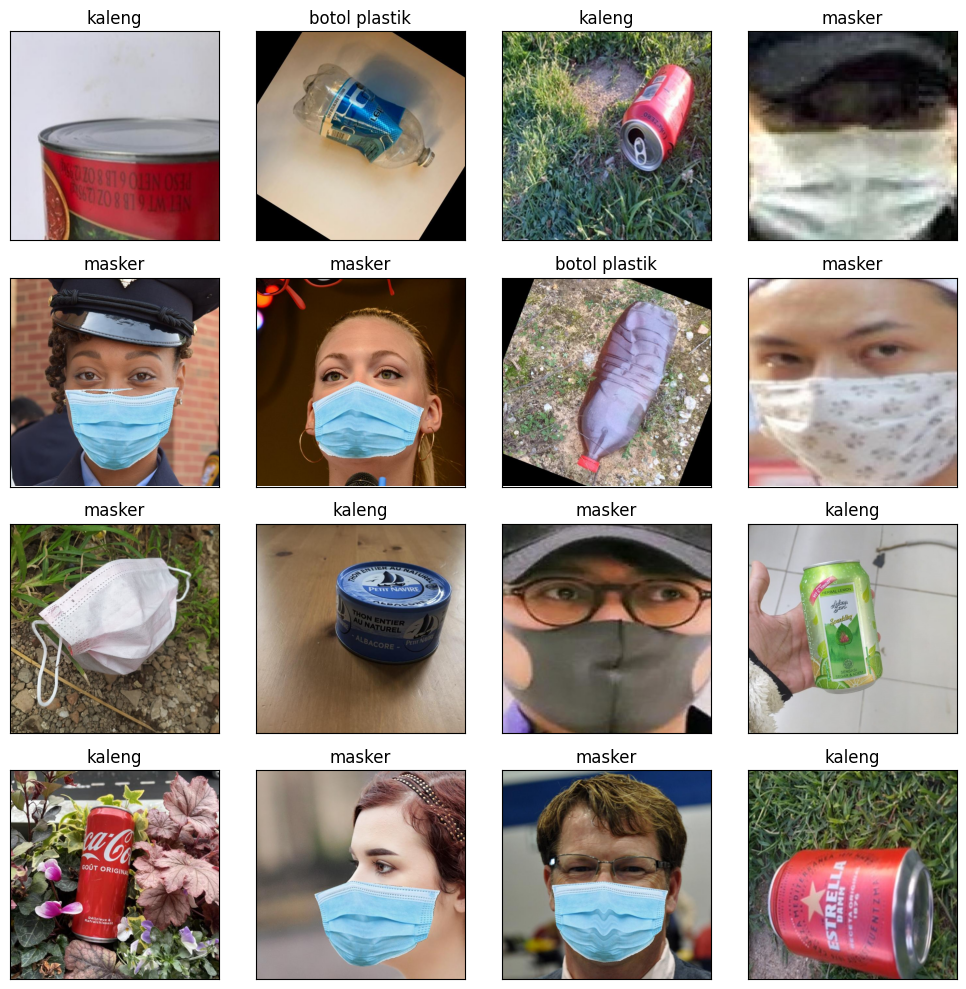

In [7]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
train_df, test_df = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=42)
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)# Split the data into three categories.
train_df['Filepath'] = train_df['Filepath'].astype(str)
test_df['Filepath'] = test_df['Filepath'].astype(str)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1080 validated image filenames belonging to 3 classes.
Found 270 validated image filenames belonging to 3 classes.
Found 150 validated image filenames belonging to 3 classes.


In [9]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [11]:
# Create checkpoint callback
checkpoint_path = "waste_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [12]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [13]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "waste-classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/waste-classification/20230704-124015
Epoch 1/20
34/34 [==============================] - 28s 736ms/step - loss: 0.7667 - accuracy: 0.7000 - val_loss: 0.4020 - val_accuracy: 0.9333
Epoch 2/20
34/34 [==============================] - 23s 690ms/step - loss: 0.3172 - accuracy: 0.9343 - val_loss: 0.1754 - val_accuracy: 0.9741
Epoch 3/20
34/34 [==============================] - 23s 689ms/step - loss: 0.1590 - accuracy: 0.9676 - val_loss: 0.0988 - val_accuracy: 0.9889
Epoch 4/20
34/34 [==============================] - 24s 693ms/step - loss: 0.0953 - accuracy: 0.9787 - val_loss: 0.0649 - val_accuracy: 0.9926
Epoch 5/20
34/34 [==============================] - 23s 692ms/step - loss: 0.0628 - accuracy: 0.9907 - val_loss: 0.0501 - val_accuracy: 0.9926
Epoch 6/20
34/34 [==============================] - 23s 688ms/step - loss: 0.0475 - accuracy: 0.9898 - val_loss: 0.0400 - val_accuracy: 0.9926
Epoch 7/20
34/34 [==============================] - 24s 70

In [14]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.01196
Test Accuracy: 100.00%


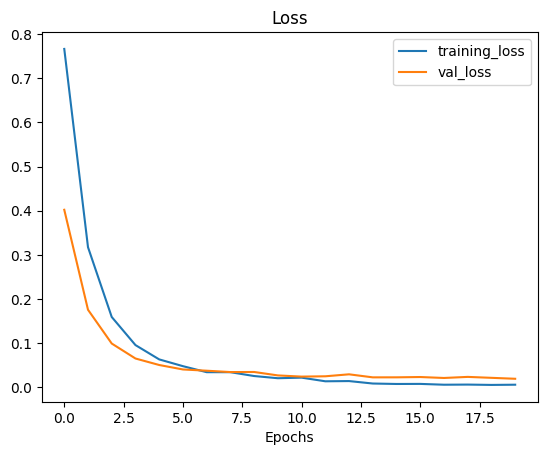

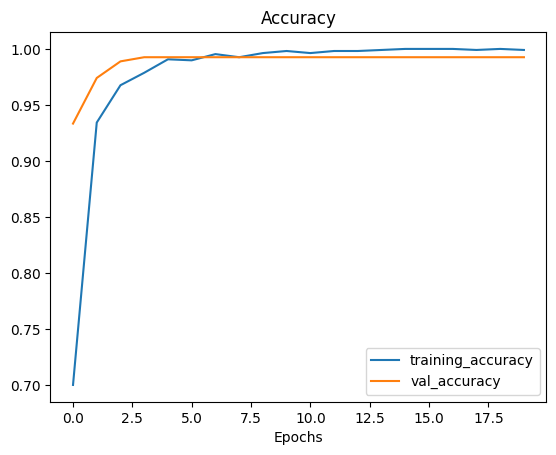

In [15]:
plot_loss_curves(history)

In [16]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

5/5 [==============================] - 3s 497ms/step
The first 5 predictions: ['masker', 'masker', 'botol plastik', 'botol plastik', 'botol plastik']


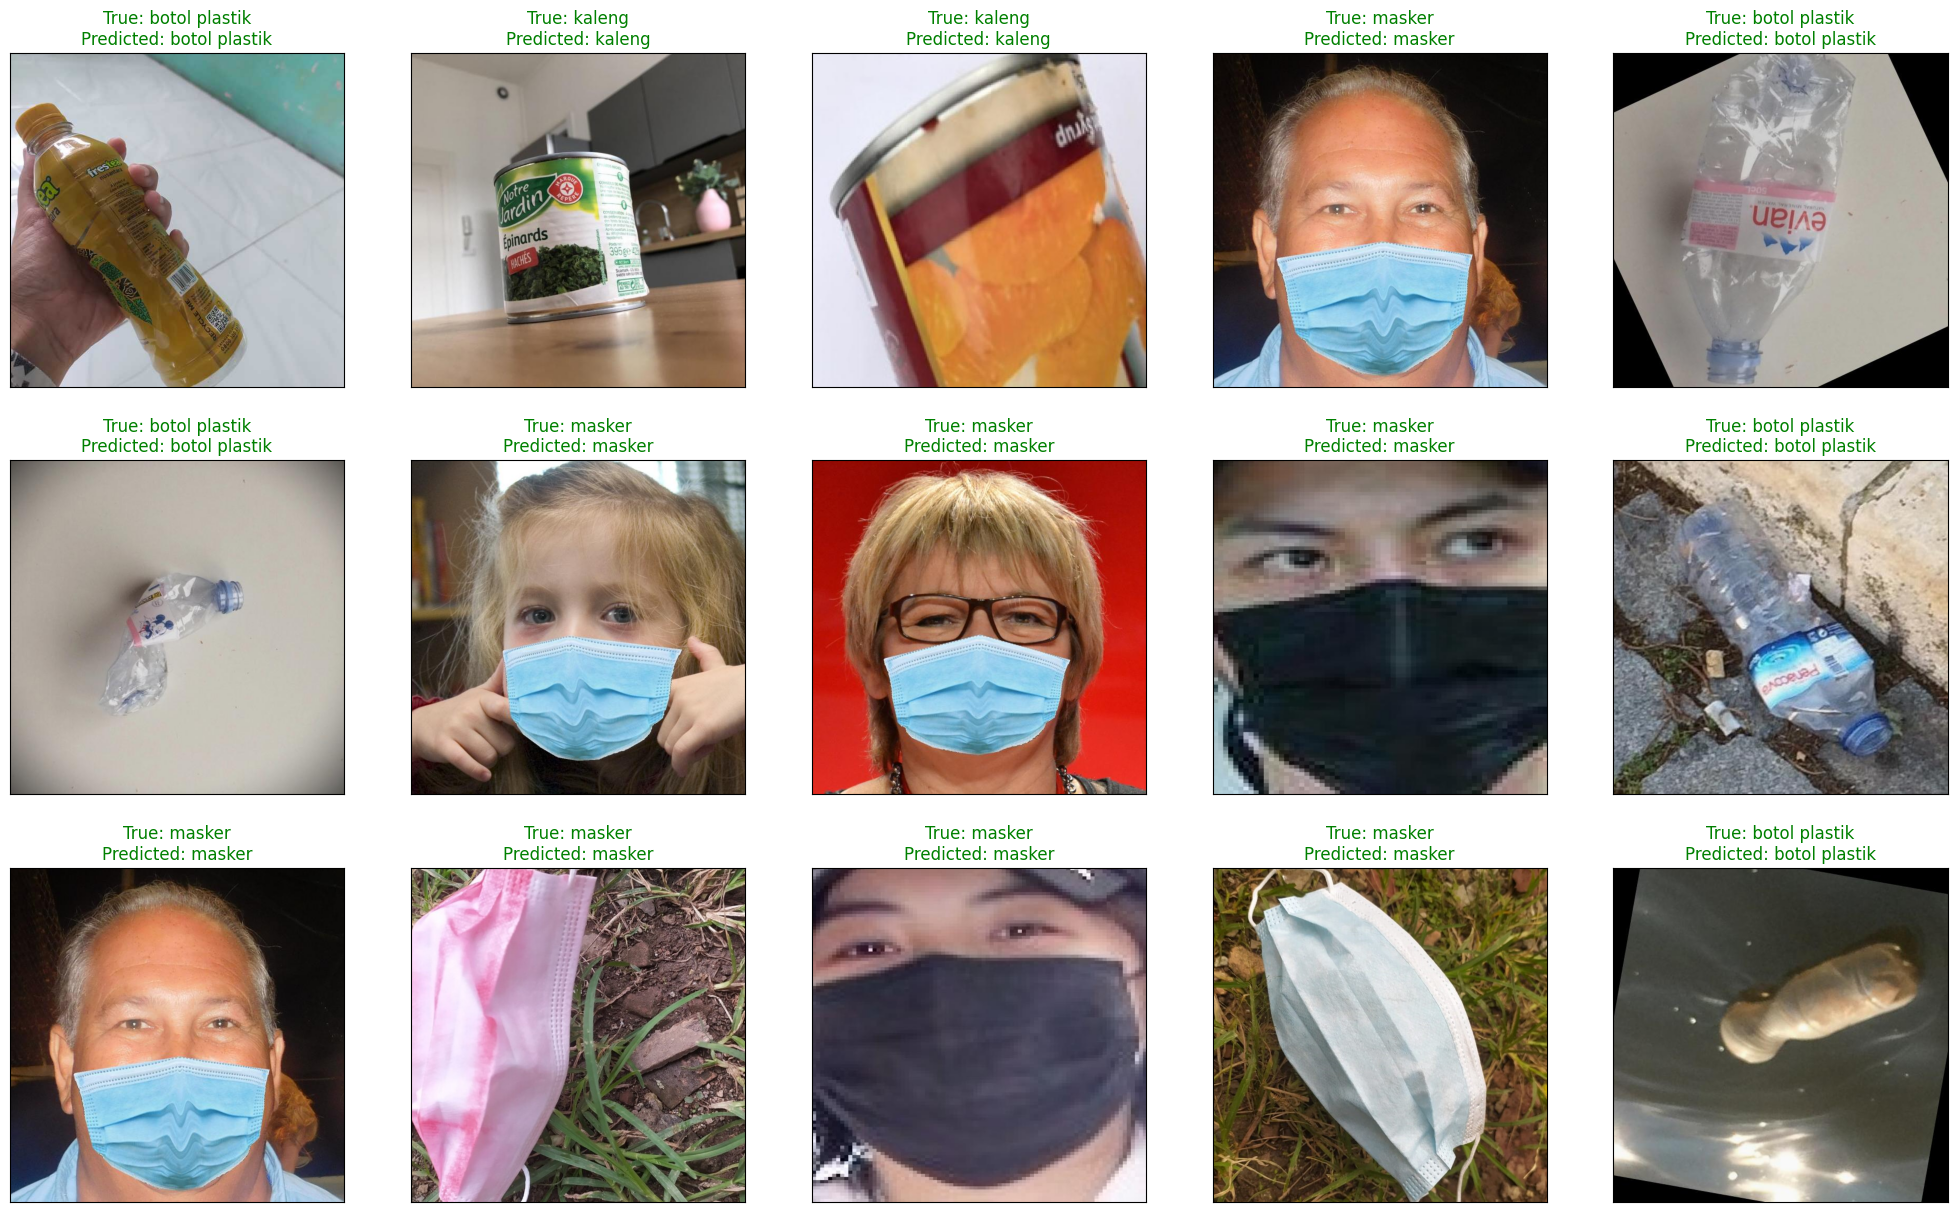

<Figure size 640x480 with 0 Axes>

In [17]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [18]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

botol plastik       1.00      1.00      1.00        58
       kaleng       1.00      1.00      1.00        41
       masker       1.00      1.00      1.00        51

     accuracy                           1.00       150
    macro avg       1.00      1.00      1.00       150
 weighted avg       1.00      1.00      1.00       150



In [19]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision  recall  f1-score  support
botol plastik        1.0     1.0       1.0     58.0
kaleng               1.0     1.0       1.0     41.0
masker               1.0     1.0       1.0     51.0
accuracy             1.0     1.0       1.0      1.0
macro avg            1.0     1.0       1.0    150.0
weighted avg         1.0     1.0       1.0    150.0

In [20]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

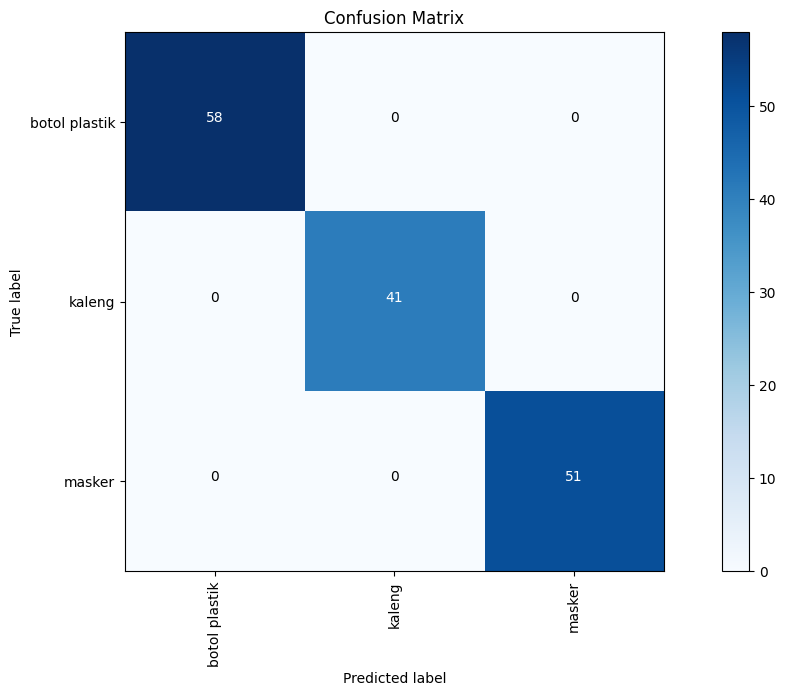

In [21]:
make_confusion_matrix(y_test, pred, list(labels.values()))


In [22]:
from keras.models import load_model

model.save('waste-cnn.h5')
del model 

model = load_model('waste-cnn.h5')

In [23]:
loss, acc = model.evaluate(test_images, verbose=2)

5/5 - 3s - loss: 0.0120 - accuracy: 1.0000 - 3s/epoch - 664ms/step
